In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
#define common variables
channels = 3 #RGB
img_w = 64
img_h = 64
input_shape = (img_h, img_w, channels)
path = "../satellite_images/images"

In [15]:
#create tf datasets from the images: tf.Data.dataset
# labels NoTrees = 0, Trees = 1

training = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=True,
    seed=47,
    validation_split=0.20,
    subset='training')

test = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=False,
    seed=47,
    validation_split=0.20,
    subset='validation')

Found 10332 files belonging to 2 classes.
Using 8266 files for training.
Found 10332 files belonging to 2 classes.
Using 2066 files for validation.


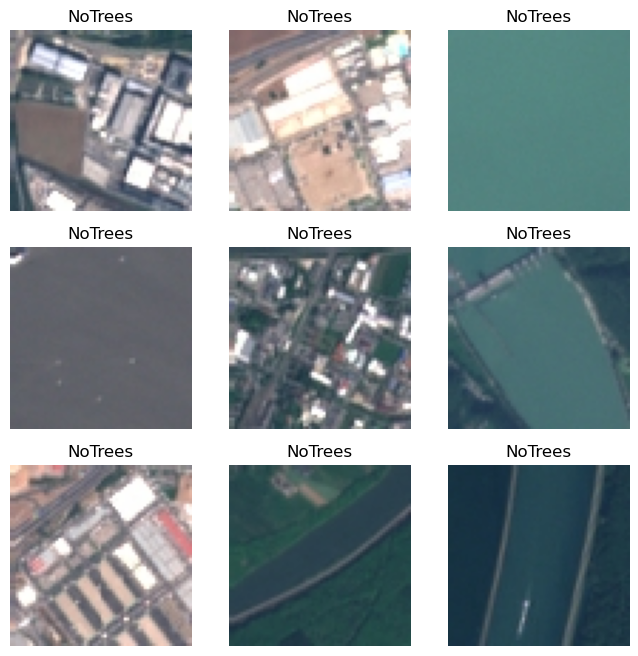

In [4]:
#show first 9 images and labels from the training set:
class_names = training.class_names

plt.figure(figsize=(8, 8))
for images, labels in training.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
        plt.axis("off")

In [18]:
# build a network from scratch
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

model_1 = Sequential()
model_1.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_1.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_1.add(MaxPool2D())
model_1.add(BatchNormalization())
model_1.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_1.add(MaxPool2D())
model_1.add(BatchNormalization())
model_1.add(Flatten())
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(1, activation='sigmoid')) #1 for binary output


In [19]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)      

In [5]:
from time import time

In [21]:
start = time()

early_stopping_monitor = EarlyStopping(patience=3)

history = model_1.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 31s 58ms/step - loss: 0.3160 - accuracy: 0.8783 - val_loss: 1.6703 - val_accuracy: 0.2614
Epoch 2/20
517/517 [==============================] - 30s 58ms/step - loss: 0.1874 - accuracy: 0.9283 - val_loss: 0.6617 - val_accuracy: 0.7991
Epoch 3/20
517/517 [==============================] - 30s 57ms/step - loss: 0.1443 - accuracy: 0.9434 - val_loss: 4.0878 - val_accuracy: 0.1980
Epoch 4/20
517/517 [==============================] - 31s 59ms/step - loss: 0.1324 - accuracy: 0.9481 - val_loss: 0.5309 - val_accuracy: 0.7875
Epoch 5/20
517/517 [==============================] - 30s 59ms/step - loss: 0.1085 - accuracy: 0.9590 - val_loss: 0.2551 - val_accuracy: 0.9240
Epoch 6/20
517/517 [==============================] - 33s 63ms/step - loss: 0.0852 - accuracy: 0.9675 - val_loss: 0.0494 - val_accuracy: 0.9879
Epoch 7/20
517/517 [==============================] - 32s 62ms/step - loss: 0.0917 - accuracy: 0.9661 - val_loss: 0.6713 - val_accuracy:

Now that I have a proper model run, I'll make a function to plot the learning curves:

In [16]:
def plot_learning_curve(history):
    tr_loss = history.history['loss']
    val_loss = history.history['val_loss']
    tr_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Plot the training and validation loss
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.plot(tr_loss, label="Training Loss", color='blue')
    plt.plot(val_loss, label="Validation Loss", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    
    # Plot the train and val accuracy
    plt.subplot(1,2,2)
    plt.plot(tr_acc, label="Training Accuracy", color='blue')
    plt.plot(val_acc, label="Validation Accuracy", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")         

    # Show the figure
    plt.show()

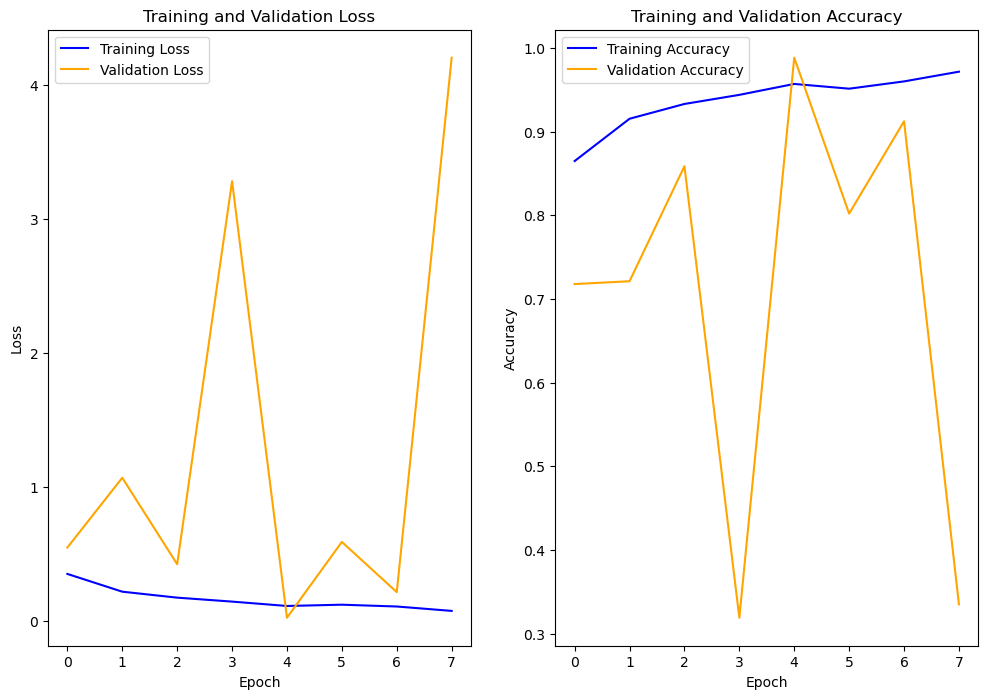

In [17]:
model_1_plots = plot_learning_curve(history)

So, it looks like improvements in the training accuracy and loss start to level off after around 10-12 epochs. The validation loss and accuracy bounce around but then appear to get worse after the 13th epoch. I will try out a slower learning rate to see if that reduces the noise in the validation learning curves and introduce early stopping:

In [36]:
#model 2
model_2 = Sequential()
model_2.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_2.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_2.add(MaxPool2D())
model_2.add(BatchNormalization())
model_2.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_2.add(MaxPool2D())
model_2.add(BatchNormalization())
model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

In [37]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    new_lr = old_lr * 0.99
    print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)
#lr_reducer = tf.keras.callbacks.LearningRateScheduler(scheduler)

start = time()

# Fit the model
history_model_2 = model_2.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 36s 67ms/step - loss: 0.3399 - accuracy: 0.8623 - val_loss: 3.3049 - val_accuracy: 0.0223
Epoch 2/20
517/517 [==============================] - 33s 64ms/step - loss: 0.2011 - accuracy: 0.9231 - val_loss: 0.1643 - val_accuracy: 0.9443
Epoch 3/20
517/517 [==============================] - 32s 62ms/step - loss: 0.1542 - accuracy: 0.9401 - val_loss: 0.1397 - val_accuracy: 0.9579
Epoch 4/20
517/517 [==============================] - 32s 62ms/step - loss: 0.1105 - accuracy: 0.9568 - val_loss: 0.0828 - val_accuracy: 0.9743
Epoch 5/20
517/517 [==============================] - 33s 63ms/step - loss: 0.0965 - accuracy: 0.9621 - val_loss: 0.1353 - val_accuracy: 0.9555
Epoch 6/20
517/517 [==============================] - 33s 63ms/step - loss: 0.0962 - accuracy: 0.9642 - val_loss: 0.5836 - val_accuracy: 0.8683
Epoch 7/20
517/517 [==============================] - 33s 64ms/step - loss: 0.0741 - accuracy: 0.9722 - val_loss: 0.4185 - val_accuracy:

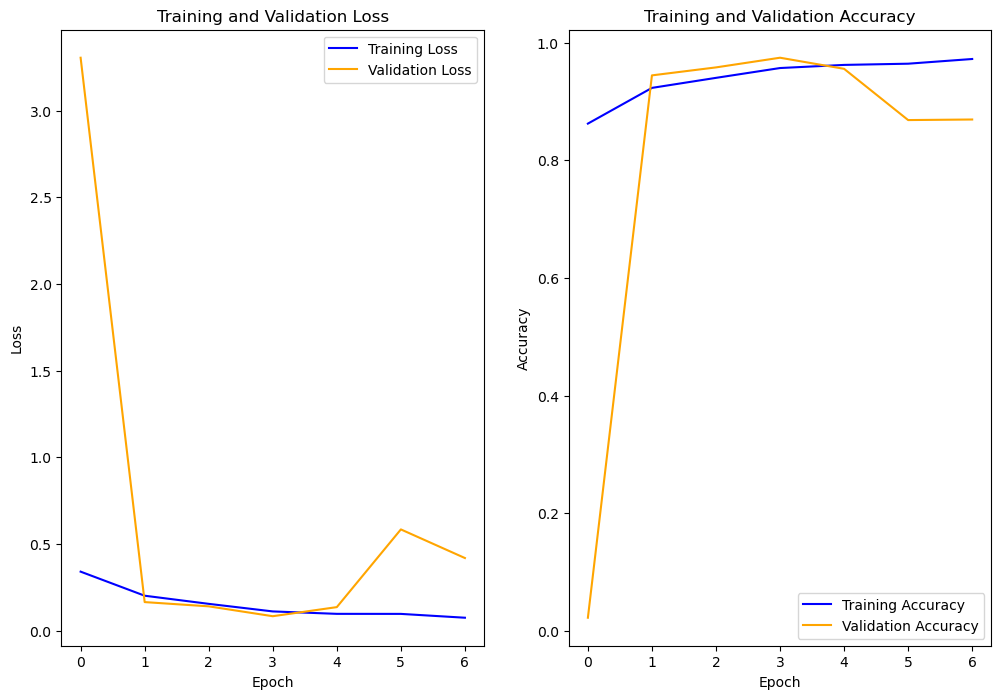

In [39]:
model_2_plots = plot_learning_curve(history_model_2)

Reducing the learning rate got rid of a lot of the jumpiness in the validation learning curves. And with the early stopping callback parameter validation accuracy hit a peak on the 3rd epoch and did not improve past that mark after three more epochs and so training stopped. 
The next network below will add more neurons to the convolutional and dense layers

In [40]:
#model 3
model_3 = Sequential()
model_3.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_3.add(Conv2D(24, kernel_size=3, padding='same', activation = 'relu'))
model_3.add(MaxPool2D())
model_3.add(BatchNormalization())
model_3.add(Conv2D(48, kernel_size=3, padding='same', activation= 'relu'))
model_3.add(MaxPool2D())
model_3.add(BatchNormalization())
model_3.add(Flatten())
model_3.add(Dense(96, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])
model_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 24)        672       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 24)       0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 24)       96        
 chNormalization)                                                
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 48)        10416     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 48)      

In [41]:
start = time()

# Fit the model
history_model_3 = model_3.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 49s 93ms/step - loss: 0.3331 - accuracy: 0.8847 - val_loss: 1.0220 - val_accuracy: 0.5440
Epoch 2/20
517/517 [==============================] - 48s 93ms/step - loss: 0.1804 - accuracy: 0.9283 - val_loss: 0.2552 - val_accuracy: 0.8819
Epoch 3/20
517/517 [==============================] - 50s 97ms/step - loss: 0.1369 - accuracy: 0.9475 - val_loss: 0.5072 - val_accuracy: 0.7967
Epoch 4/20
517/517 [==============================] - 52s 101ms/step - loss: 0.1158 - accuracy: 0.9550 - val_loss: 0.2005 - val_accuracy: 0.9172
Epoch 5/20
517/517 [==============================] - 53s 102ms/step - loss: 0.1070 - accuracy: 0.9592 - val_loss: 1.6411 - val_accuracy: 0.5431
Epoch 6/20
517/517 [==============================] - 46s 89ms/step - loss: 0.0918 - accuracy: 0.9639 - val_loss: 0.1417 - val_accuracy: 0.9661
Epoch 7/20
517/517 [==============================] - 46s 89ms/step - loss: 0.0714 - accuracy: 0.9714 - val_loss: 0.5624 - val_accurac

So with this network with more neurons, validation accuracy and loss are very volatile again, even with the reduced learning rate. 

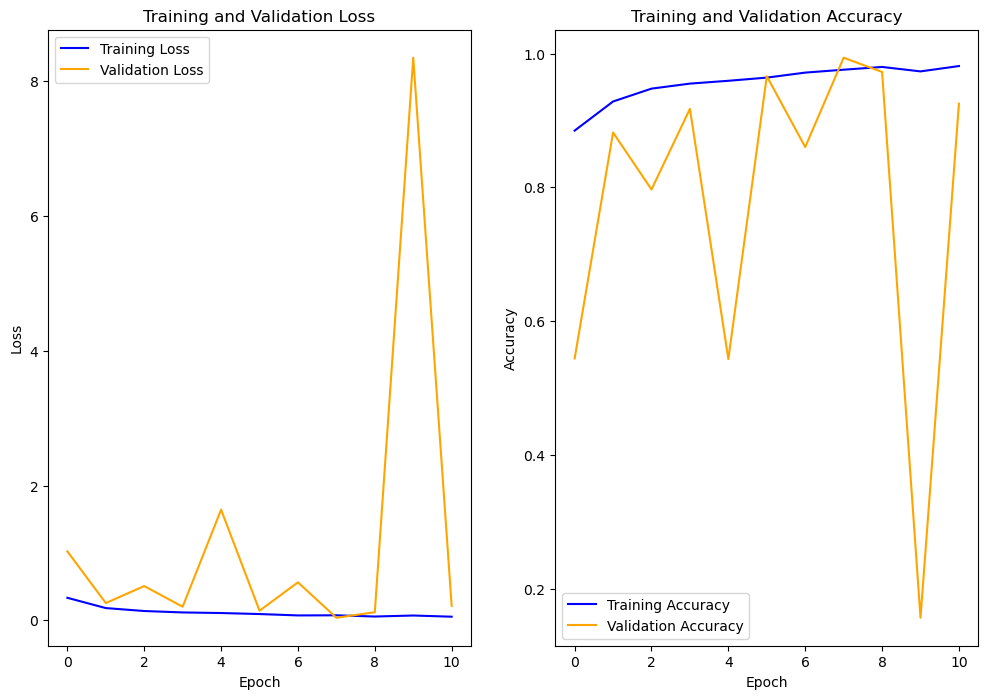

In [42]:
model_3_plots = plot_learning_curve(history_model_3)

I'll now try a model similar to model 2 with the original numebr of neurons, but with sigmoid instead of relu activation functions for the convolutional layers:

In [43]:
#model 4
model_4 = Sequential()
model_4.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_4.add(Conv2D(16, kernel_size=3, padding='same', activation = 'sigmoid'))
model_4.add(MaxPool2D())
model_4.add(BatchNormalization())
model_4.add(Conv2D(32, kernel_size=3, padding='same', activation= 'sigmoid'))
model_4.add(MaxPool2D())
model_4.add(BatchNormalization())
model_4.add(Flatten())
model_4.add(Dense(64, activation='sigmoid'))
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])
model_4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 32)      

In [44]:
# we'll do early stopping again
start = time()

# Fit the model
history_model_4 = model_4.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 36s 66ms/step - loss: 0.3689 - accuracy: 0.8385 - val_loss: 0.7970 - val_accuracy: 0.5131
Epoch 2/20
517/517 [==============================] - 37s 72ms/step - loss: 0.2753 - accuracy: 0.8883 - val_loss: 0.4194 - val_accuracy: 0.8035
Epoch 3/20
517/517 [==============================] - 35s 68ms/step - loss: 0.2466 - accuracy: 0.8989 - val_loss: 0.5084 - val_accuracy: 0.7556
Epoch 4/20
517/517 [==============================] - 41s 80ms/step - loss: 0.2033 - accuracy: 0.9194 - val_loss: 0.1970 - val_accuracy: 0.9100
Epoch 5/20
517/517 [==============================] - 40s 78ms/step - loss: 0.1660 - accuracy: 0.9338 - val_loss: 0.1727 - val_accuracy: 0.9269
Epoch 6/20
517/517 [==============================] - 36s 70ms/step - loss: 0.1424 - accuracy: 0.9477 - val_loss: 1.6477 - val_accuracy: 0.3461
Epoch 7/20
517/517 [==============================] - 35s 67ms/step - loss: 0.1303 - accuracy: 0.9510 - val_loss: 0.3660 - val_accuracy:

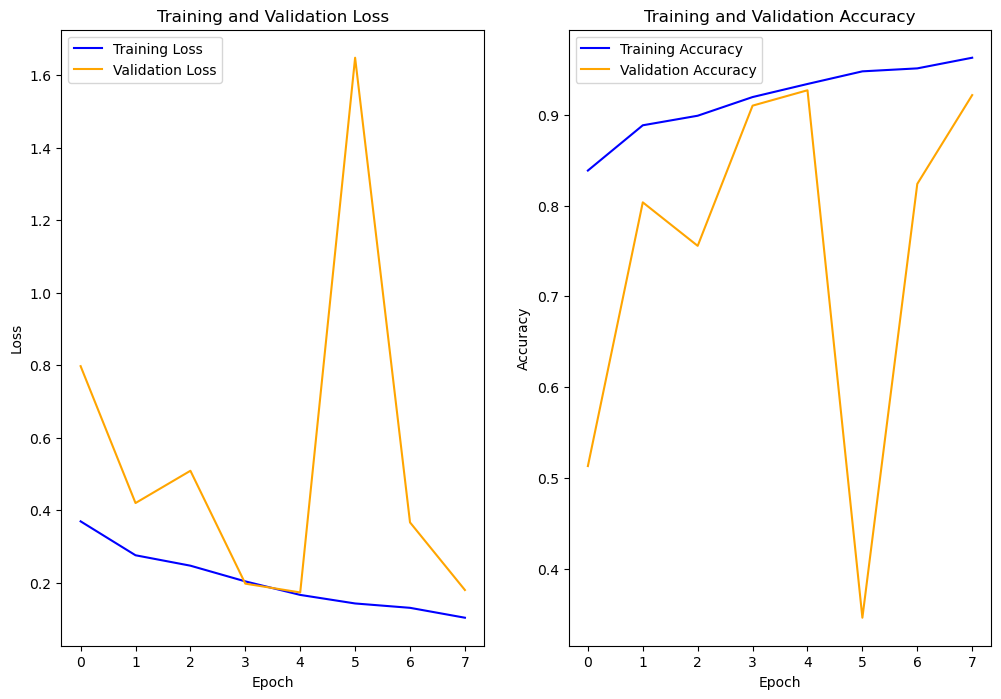

In [47]:
model_4_plots = plot_learning_curve(history_model_4)

With sigmoid activation functions in the convolutional layers, the network hits peak validation accuracy after the 9th epoch and stops early after the 12th when validation accuracy does not improve further.

In [48]:
max(history_model_4.history['val_accuracy'])

0.9269118905067444

In [49]:
max(history_model_3.history['val_accuracy'])

0.9937076568603516

So the network with two convolutional layers and one dense layer all using the relu activation function performed better than the one with sigmoid activation functions. And the validation loss and accuracy are still very volatile even with the reduced learning rate. I could try reducing it further. And after that, I will try an additional convolutional layer, using relu activation again.

In [52]:
model_4a = Sequential()
model_4a.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_4a.add(Conv2D(16, kernel_size=3, padding='same', activation = 'sigmoid'))
model_4a.add(MaxPool2D())
model_4a.add(BatchNormalization())
model_4a.add(Conv2D(32, kernel_size=3, padding='same', activation= 'sigmoid'))
model_4a.add(MaxPool2D())
model_4a.add(BatchNormalization())
model_4a.add(Flatten())
model_4a.add(Dense(64, activation='sigmoid'))
model_4a.add(Dense(1, activation='sigmoid'))

model_4a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
start = time()

# Fit the model
history_model_4a = model_4a.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 34s 63ms/step - loss: 0.3911 - accuracy: 0.8242 - val_loss: 0.5302 - val_accuracy: 0.7280
Epoch 2/20
517/517 [==============================] - 33s 65ms/step - loss: 0.2879 - accuracy: 0.8817 - val_loss: 0.1961 - val_accuracy: 0.9197
Epoch 3/20
517/517 [==============================] - 34s 65ms/step - loss: 0.2470 - accuracy: 0.9015 - val_loss: 0.2545 - val_accuracy: 0.8945
Epoch 4/20
517/517 [==============================] - 34s 65ms/step - loss: 0.2063 - accuracy: 0.9192 - val_loss: 0.1453 - val_accuracy: 0.9526
Epoch 5/20
517/517 [==============================] - 34s 65ms/step - loss: 0.1820 - accuracy: 0.9292 - val_loss: 0.2405 - val_accuracy: 0.8916
Epoch 6/20
517/517 [==============================] - 34s 66ms/step - loss: 0.1579 - accuracy: 0.9399 - val_loss: 0.2253 - val_accuracy: 0.9085
Epoch 7/20
517/517 [==============================] - 33s 65ms/step - loss: 0.1290 - accuracy: 0.9554 - val_loss: 0.8482 - val_accuracy:

In [54]:
#model 5
model_5 = Sequential()
model_5.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_5.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_5.add(MaxPool2D())
model_5.add(BatchNormalization())
model_5.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_5.add(MaxPool2D())
model_5.add(BatchNormalization())
model_5.add(Conv2D(64, kernel_size=3, padding='same', activation = 'relu'))
model_5.add(Flatten())
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])
model_5.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 16, 16, 32)      

In [55]:
start = time()

# Fit the model
history_model_5 = model_5.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 40s 75ms/step - loss: 0.2874 - accuracy: 0.8869 - val_loss: 2.5020 - val_accuracy: 0.1026
Epoch 2/20
517/517 [==============================] - 40s 77ms/step - loss: 0.1793 - accuracy: 0.9337 - val_loss: 0.1145 - val_accuracy: 0.9618
Epoch 3/20
517/517 [==============================] - 40s 77ms/step - loss: 0.1475 - accuracy: 0.9446 - val_loss: 0.1464 - val_accuracy: 0.9492
Epoch 4/20
517/517 [==============================] - 40s 78ms/step - loss: 0.1260 - accuracy: 0.9523 - val_loss: 0.1405 - val_accuracy: 0.9618
Epoch 5/20
517/517 [==============================] - 40s 77ms/step - loss: 0.0982 - accuracy: 0.9621 - val_loss: 0.3930 - val_accuracy: 0.8722
Elapsed Time = 200.40778350830078 seconds


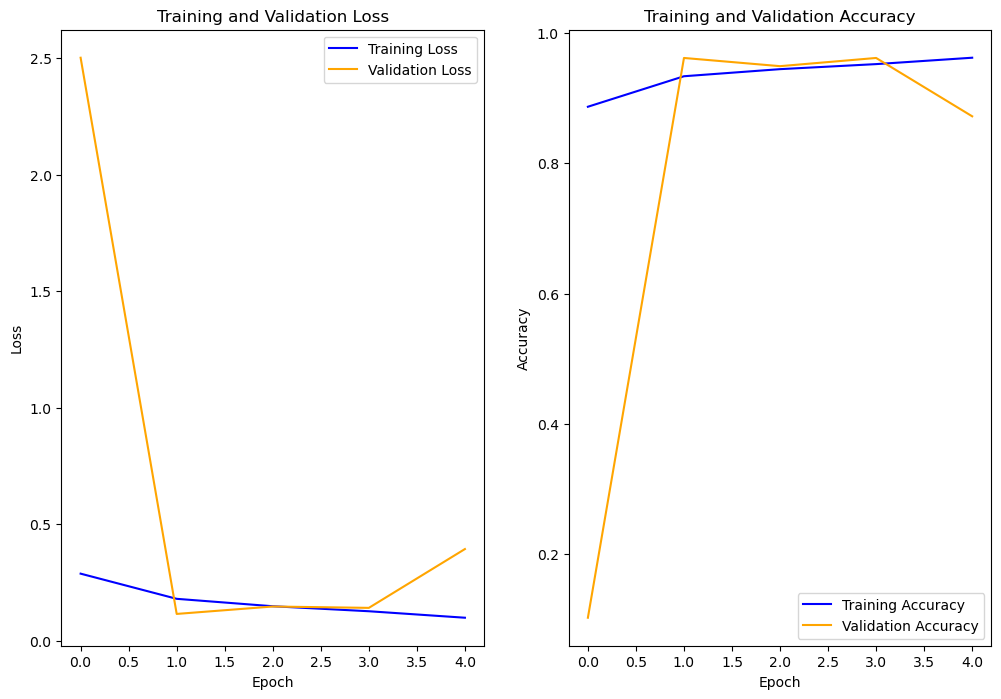

In [59]:
model_5_plots = plot_learning_curve(history_model_5)

I'll try a model similar to 5, but with SGD optimizer instead of adam

In [56]:
#model 5a
model_5a = Sequential()
model_5a.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_5a.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_5a.add(MaxPool2D())
model_5a.add(BatchNormalization())
model_5a.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_5a.add(MaxPool2D())
model_5a.add(BatchNormalization())
model_5a.add(Conv2D(64, kernel_size=3, padding='same', activation = 'relu'))
model_5a.add(Flatten())
model_5a.add(Dense(64, activation='relu'))
model_5a.add(Dense(1, activation='sigmoid'))

model_5a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])


In [57]:
start = time()

# Fit the model
history_model_5a = model_5a.fit(training, validation_data=test, epochs=12)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/12
517/517 [==============================] - 35s 65ms/step - loss: 0.3383 - accuracy: 0.8563 - val_loss: 1.0602 - val_accuracy: 0.2648
Epoch 2/12
517/517 [==============================] - 34s 66ms/step - loss: 0.2545 - accuracy: 0.8944 - val_loss: 0.3757 - val_accuracy: 0.8524
Epoch 3/12
517/517 [==============================] - 34s 66ms/step - loss: 0.2259 - accuracy: 0.9105 - val_loss: 0.2545 - val_accuracy: 0.9143
Epoch 4/12
517/517 [==============================] - 34s 66ms/step - loss: 0.2047 - accuracy: 0.9192 - val_loss: 0.2574 - val_accuracy: 0.9017
Epoch 5/12
517/517 [==============================] - 34s 66ms/step - loss: 0.1825 - accuracy: 0.9296 - val_loss: 0.1656 - val_accuracy: 0.9521
Epoch 6/12
517/517 [==============================] - 34s 67ms/step - loss: 0.1656 - accuracy: 0.9371 - val_loss: 0.3135 - val_accuracy: 0.8683
Epoch 7/12
517/517 [==============================] - 34s 66ms/step - loss: 0.1543 - accuracy: 0.9405 - val_loss: 0.1936 - val_accuracy:

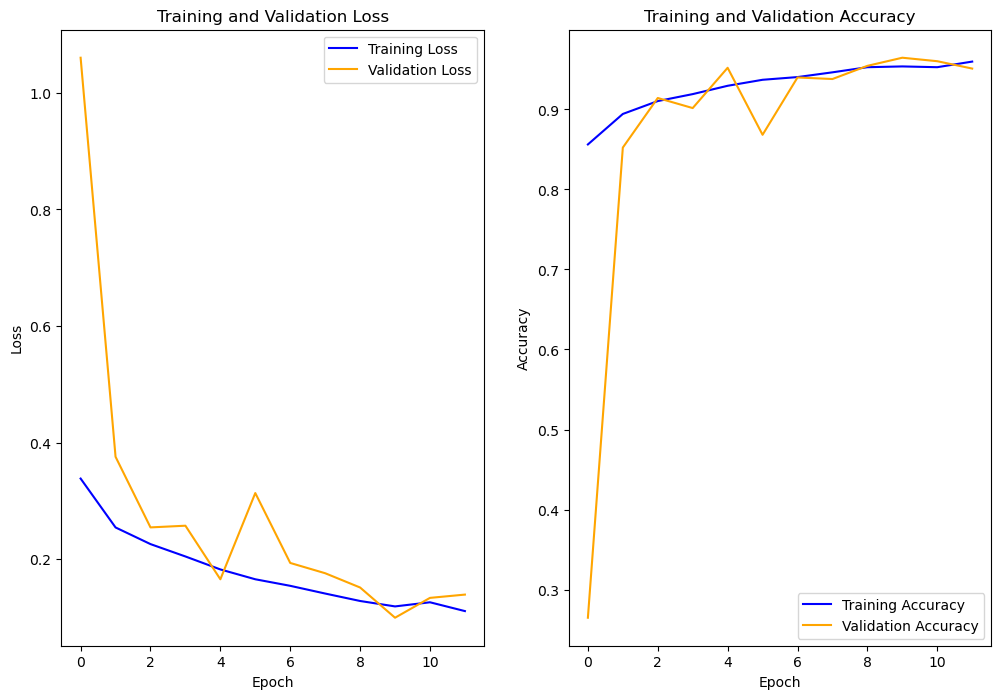

In [58]:
model_5a_plots = plot_learning_curve(history_model_5a)